In [1]:
%load_ext autoreload
%autoreload 2

from model import LitS4Model
from data import LitDataModule
from plotting import *
import torch
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import tqdm
import numpy as np

In [2]:
path = '/home/lfd34/project/project8/ssm/neutrino_project/runs/noise_fftandts2channels_dmodel18_layers6_lr1e-3_gamma0.99_batchsize256_longrun_12000points_actuallythisone/lightning_logs/fz29so1e'
CHECKPOINT = os.path.join(path, 'checkpoints/last.ckpt')
image_folder = os.path.join(path, 'results')

In [3]:
! mkdir "{image_folder}"

mkdir: cannot create directory ‘/home/lfd34/project/project8/ssm/neutrino_project/runs/noise_fftandts2channels_dmodel18_layers6_lr1e-3_gamma0.99_batchsize256_longrun_12000points_actuallythisone/lightning_logs/fz29so1e/results’: File exists


In [4]:
model = LitS4Model.load_from_checkpoint(CHECKPOINT)
model = model.to(device)
model = model.eval()

/home/lfd34/.conda/envs/ssm/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [5]:
#dataset = LitDataModule.load_from_checkpoint(CHECKPOINT, inputs=['output_ts_I'], variables=model.variables)
dataset = LitDataModule.load_from_checkpoint(CHECKPOINT)

In [6]:
true = []
pred = []
meta = []

for ts,var,obs in dataset.test_dataloader():
    with torch.no_grad():
        pred.append(model(ts.to(device)).cpu().numpy())
        true.append(var.numpy())
        meta.append(obs.numpy())

/home/lfd34/.conda/envs/ssm/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/lfd34/.conda/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn

In [7]:
#true = np.concatenate(true)
#pred = np.concatenate(pred)

true = np.concatenate(true, axis=0)
pred = np.concatenate(pred, axis=0)
meta = np.concatenate(meta, axis=0)

In [8]:
# undo the normalization
pred_post = pred * dataset.stds + dataset.mu
true_post = true * dataset.stds + dataset.mu

/home/lfd34/project/project8/ssm/neutrino_project/runs/noise_fftandts2channels_dmodel18_layers6_lr1e-3_gamma0.99_batchsize256_longrun_12000points_actuallythisone/lightning_logs/fz29so1e/results


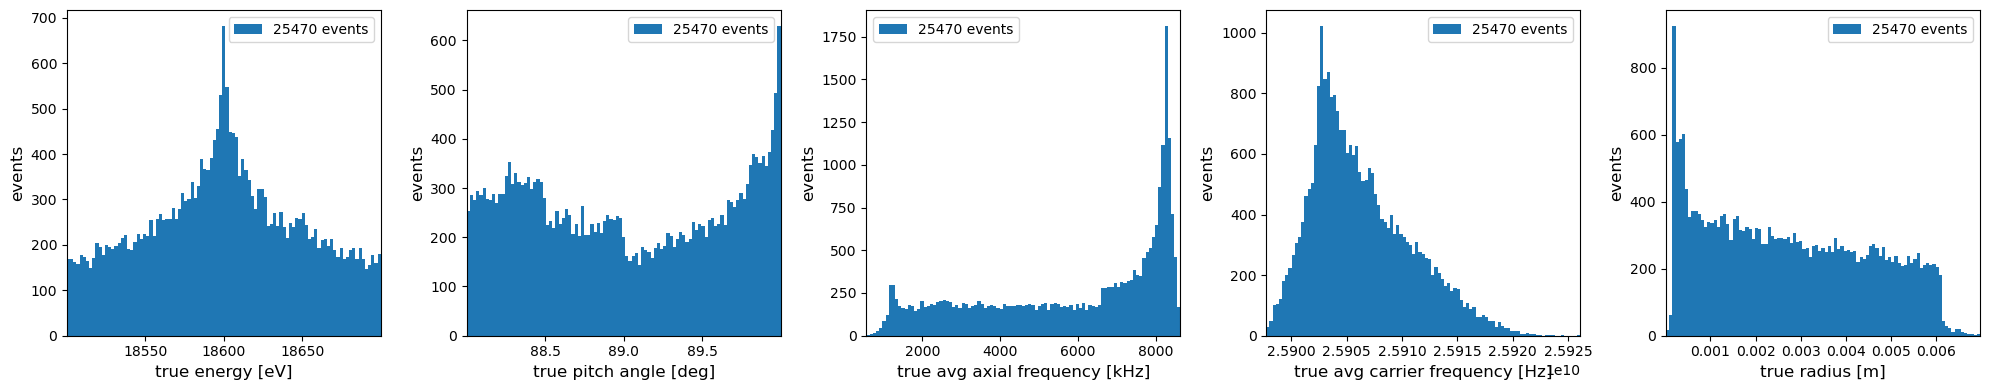

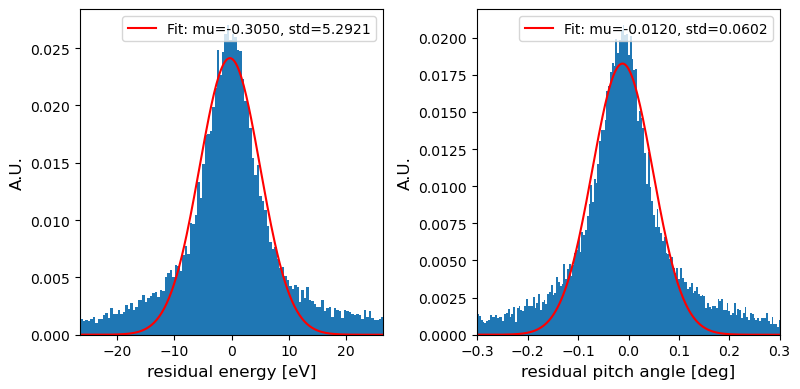

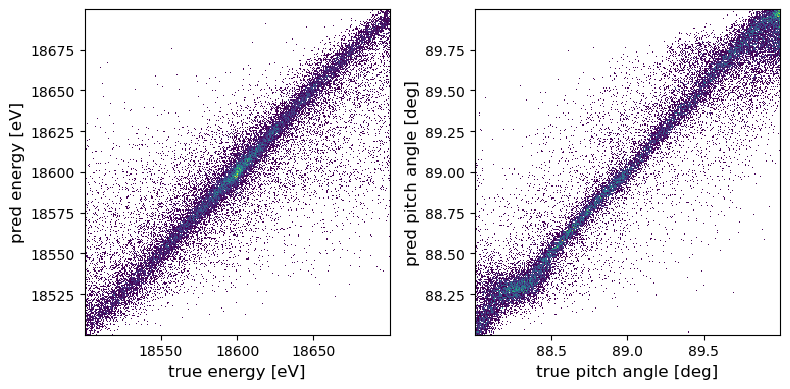

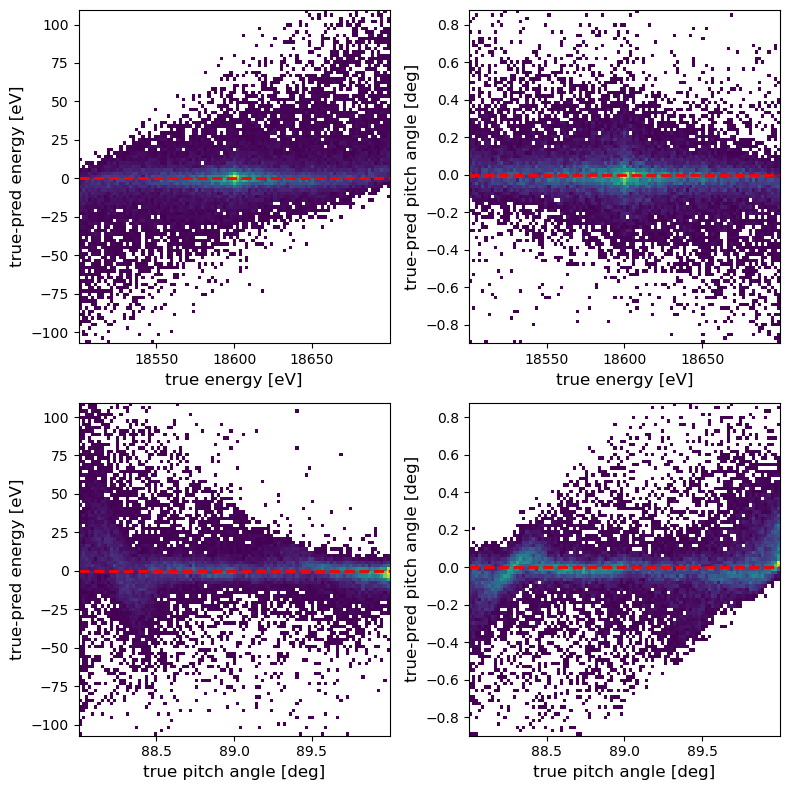

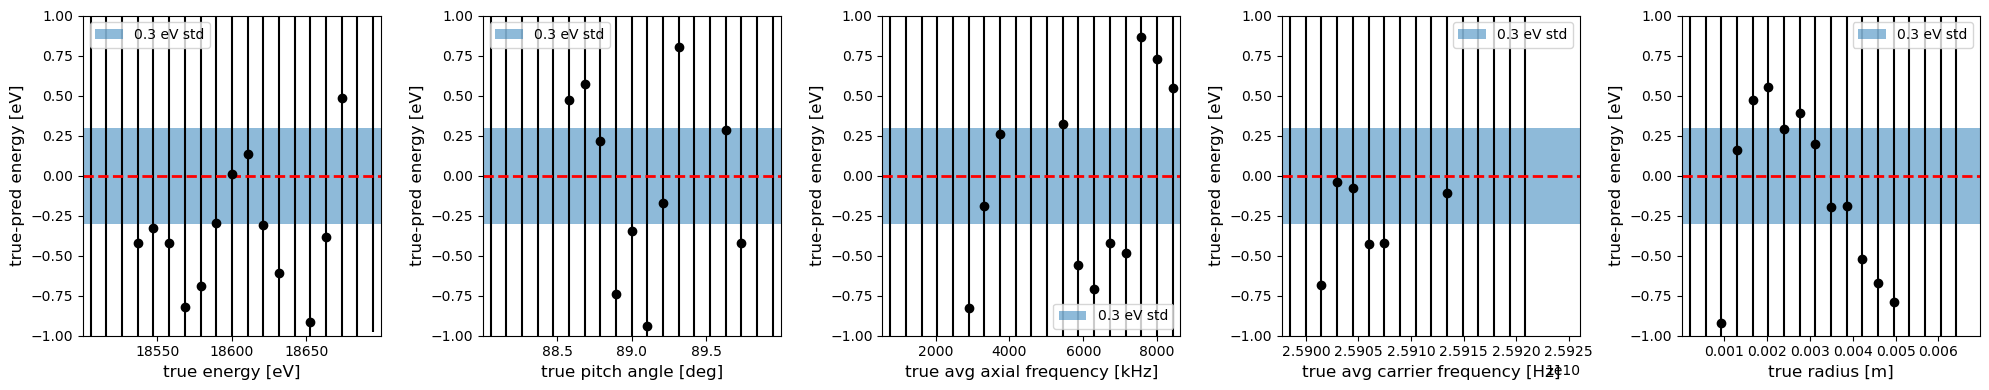

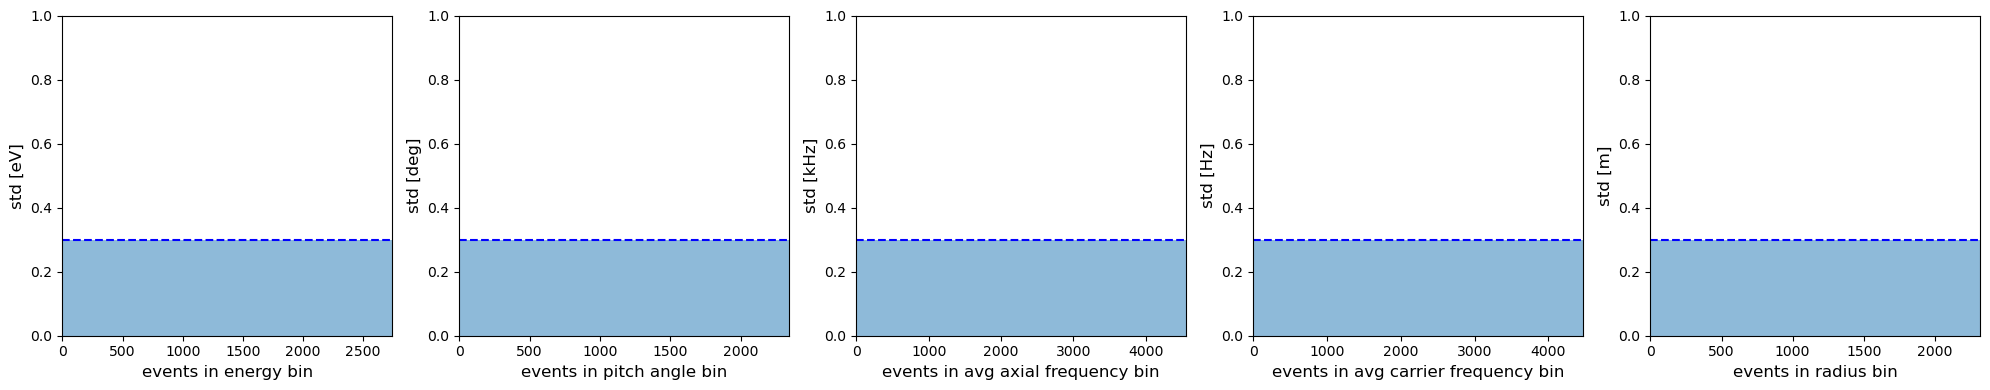

In [9]:
f = make_all_plots(dataset.variables, dataset.observables,true_post, pred_post, meta, folder=image_folder, savefigs=True)

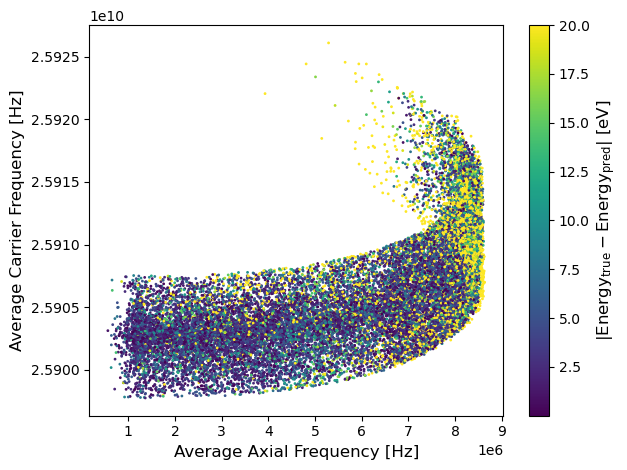

In [10]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

avg_axial_frequency_Hz = meta[:, 0]
avg_carrier_frequency_Hz = meta[:, 1]
true_energy = true_post[:, 0]
pred_energy = pred_post[:, 0]

fig, ax = plt.subplots()

sc = ax.scatter(
    avg_axial_frequency_Hz,
    avg_carrier_frequency_Hz,
    c=np.abs(true_energy - pred_energy),
    s=1,
    cmap='viridis', 
    vmax=20
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$|\text{Energy}_{\text{true}} - \text{Energy}_{\text{pred}}|$ [eV]")

plt.xlabel("Average Axial Frequency [Hz]")
plt.ylabel("Average Carrier Frequency [Hz]")

plt.tight_layout()
plt.show()


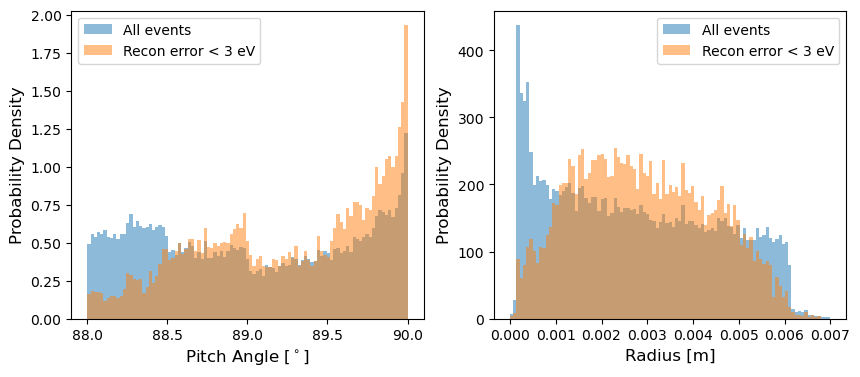

In [11]:
# true, pred: energy_eV, pitch_angle_deg
# meta: avg_axial_frequency_Hz, avg_carrier_frequency_Hz, radius_m

pitch_angle_bins = np.linspace(88, 90, 100)
radius_bins = np.linspace(0, 0.007, 100)

true_pitch_angles = true_post[:,1]
true_radii = meta[:,2]
true_energies = true_post[:,0]
pred_energies = pred_post[:,0]
recon_mask = np.abs(true_energies - pred_energies) < 3

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(true_pitch_angles, bins=pitch_angle_bins, density=True, alpha = 0.5, label="All events")
ax[0].hist(true_pitch_angles[recon_mask], bins=pitch_angle_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[0].legend()
ax[0].set_xlabel(r"Pitch Angle [$^\circ$]")
ax[0].set_ylabel("Probability Density")
ax[1].hist(true_radii, bins=radius_bins, density=True, alpha = 0.5, label="All events")
ax[1].hist(true_radii[recon_mask], bins=radius_bins, density=True, alpha = 0.5, label="Recon error < 3 eV")
ax[1].set_xlabel(r"Radius [m]")
ax[1].set_ylabel("Probability Density")
ax[1].legend()
plt.show()

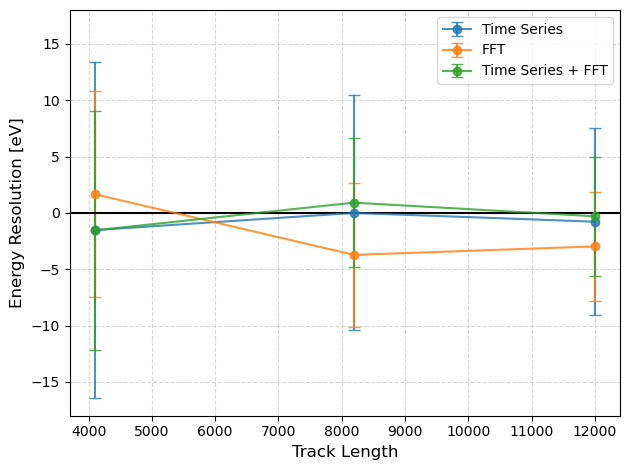

In [15]:
sizes = np.array([4096,8192,12000])
ts_resolution_bias = np.array([-1.5275,-0.0072,-0.7850])
ts_resolution_std = np.array([14.8861,10.4238,8.2875])
fft_resolution_bias = np.array([1.6569,-3.7276,-2.9765])
fft_resolution_std = np.array([9.1209,6.3788,4.8629])
ts_and_fft_resolution_bias = np.array([-1.5514, 0.9063,-0.3050])
ts_and_fft_resolution_std = np.array([10.5960,5.7198,5.2921])

fig, ax = plt.subplots()
ax.errorbar(
    sizes, ts_resolution_bias, yerr=ts_resolution_std,
    fmt='o-', color='tab:blue', ecolor='tab:blue', elinewidth=1.5, capsize=4,
    label='Time Series', markersize=6, alpha=0.8
)

ax.errorbar(
    sizes, fft_resolution_bias, yerr=fft_resolution_std,
    fmt='o-', color='tab:orange', ecolor='tab:orange', elinewidth=1.5, capsize=4,
    label='FFT', markersize=6, alpha=0.8
)

ax.errorbar(
    sizes, ts_and_fft_resolution_bias, yerr=ts_and_fft_resolution_std,
    fmt='o-', color='tab:green', ecolor='tab:green', elinewidth=1.5, capsize=4,
    label='Time Series + FFT', markersize=6, alpha=0.8
)

ax.axhline(y=0, color='black')

ax.set_xlabel("Track Length")
ax.set_ylabel("Energy Resolution [eV]")
ax.set_ylim(-18,18)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
from scipy.optimize import curve_fit

def linear(x, slope, intercept):
    return slope*x + intercept

(slope_fft, intercept_fft), _ = curve_fit(linear, sizes, fft_resolution_std)

(slope_ts, intercept_ts), _ = curve_fit(linear, sizes, ts_resolution_std)

(slope_ts_and_fft, intercept_ts_and_fft), _ = curve_fit(linear, sizes, ts_and_fft_resolution_std)

print(f"fft: slope = {slope_fft}, intersect = {intercept_fft}")
print(f"ts: slope = {slope_ts}, intersect = {intercept_ts}")
print(f"ts: slope = {slope_ts_and_fft}, intersect = {intercept_ts_and_fft}")

desired_res = 0.3 #eV
print(f"expected number of points to resolution")
print(f"ts: {(desired_res - intercept_ts)/slope_ts}, fft: {(desired_res - intercept_fft)/slope_fft}, both: {(desired_res - intercept_ts_and_fft)/slope_ts_and_fft}")

fft: slope = -0.0005403596849311339, intersect = 11.162285342535792
ts: slope = -0.0008380465019238629, intersect = 17.983957812908926
ts: slope = -0.000677575940972952, intersect = 12.68828813380726
expected number of points to resolution
ts: 21101.404005998138, fft: 20101.953653185905, both: 18283.246769385787


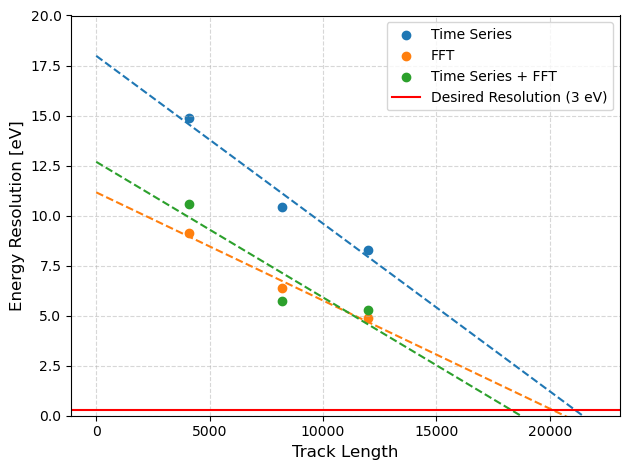

In [17]:
x_line = np.linspace(0,22000, 1000)

fig, ax = plt.subplots()
ax.scatter(sizes, ts_resolution_std, color='tab:blue', label="Time Series")
ax.scatter(sizes, fft_resolution_std, color='tab:orange', label="FFT")
ax.scatter(sizes, ts_and_fft_resolution_std, color='tab:green', label="Time Series + FFT")
ax.plot(x_line, linear(x_line, slope_ts, intercept_ts), ls="--", color='tab:blue')
ax.plot(x_line, linear(x_line, slope_fft, intercept_fft), ls="--", color='tab:orange')
ax.plot(x_line, linear(x_line, slope_ts_and_fft, intercept_ts_and_fft), ls="--", color='tab:green')
ax.axhline(y=0.3, color='r', label="Desired Resolution (3 eV)")
ax.set_xlabel("Track Length")
ax.set_ylabel("Energy Resolution [eV]")
ax.set_ylim(0,20)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()